In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

# using Plots
using CairoMakie
using Random
using Parameters
using Printf
using DataFrames
using GraphRecipes
using JLD
using StatsPlots
using LinearAlgebra

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

df_current = filter(:n_traj=>x->x==2500,df);

evolutionary_runs = Dict{String,Any}("classical"=>df_current[:,"raw_data"][1],"feed_forward"=>df_current[:,"raw_data"][2],"mutual_inh"=>df_current[:,"raw_data"][3],"overlap_dom"=>df_current[:,"raw_data"][4]);

┌ Info: Scanning folder /Users/boothh/Documents/GRNEvoContingency/data/sims/repeated_evolution_different_topologies for result files.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:115
┌ Info: Added 8 entries.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:191


In [207]:
topology = "mutual_inh"
start_network = example_networks[topology]
run_data = evolutionary_runs[topology];

In [208]:
# w_path = map(x->unique(x[2].traversed_topologies),run_data);

# w_path_vec = map(p->map(m->vec(m),p[2:end]),w_path);

# path_data = reduce(hcat,map(x->reduce(hcat,x),w_path_vec));

In [209]:
end_networks = map(x->x[1].dominant_individual.genotype.p[1],run_data);
first_networks = map(x->unique(x[2].traversed_topologies)[2],run_data);

In [210]:
mutations = map(v->v[2:end] .- v[1:end-1],traversed_networks);
mutation_id = map(m->map(x -> findall(y->abs.(y).> 0,x)[1],m),mutations);

function get_transition_prob(n,mutation_id)
    mutation_level_n = map(x->x[n],filter(m->length(m) >= n,mutation_id))

    Dict(i => v/length(mutation_level_n) for (i,v) in countmap(mutation_level_n))
end

tn_v = map(m->map(x->vec(x),m),traversed_networks);
tn_vd = map(x->reduce(hcat,x),tn_v);

plot(transpose(tn_vd[1]))

plot(value_c,xticks = (1:length(xtick_l),xtick_l))

UndefVarError: UndefVarError: plot not defined

In [211]:
matrix_entries = [(1,1),(2,1),(3,1),(1,2),(2,2),(3,2),(1,3),(2,3),(3,3),(1,4),(2,4),(3,4)];

In [212]:
function matrix_entropy(m)
    v = svd(m).S
    p = v.^2 ./ sum(v.^2)
    rank_m =  sum(v.>0)

    return (-1/log(rank_m))*sum(p .* log.(p))
end

matrix_entropy (generic function with 1 method)

In [213]:
m = rand(3,4)

3×4 Matrix{Float64}:
 0.199125  0.976845  0.90338   0.0532472
 0.281656  0.351067  0.920869  0.649351
 0.873896  0.432126  0.123569  0.842042

In [214]:
matrix_entropy(m)

0.6291634175753138

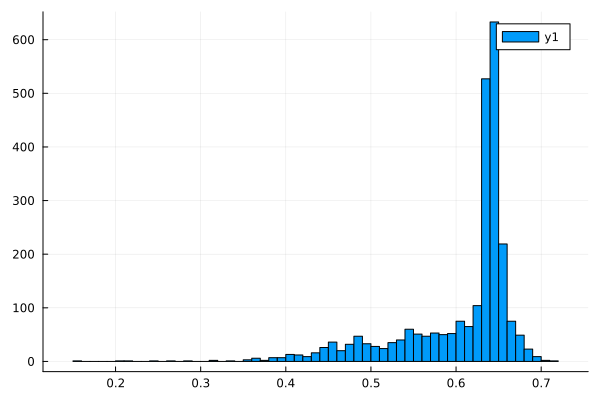

In [215]:
histogram(map(x->matrix_entropy(x),end_networks))

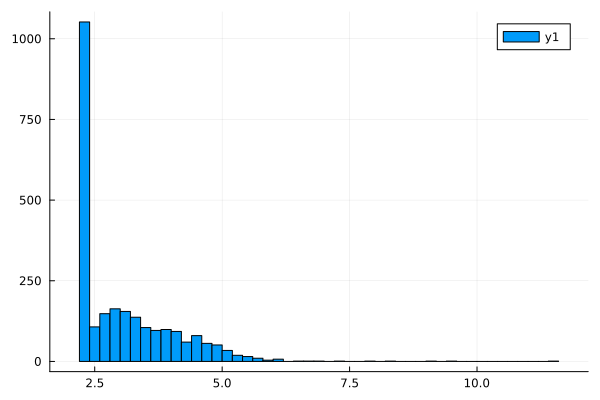

In [216]:
histogram(map(x->maximum(svd(x).S),end_networks))

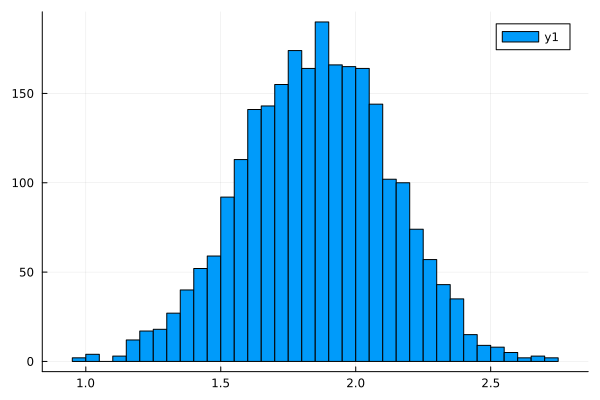

In [217]:
histogram(map(x->maximum(svd(rand(3,4)).S),first_networks))

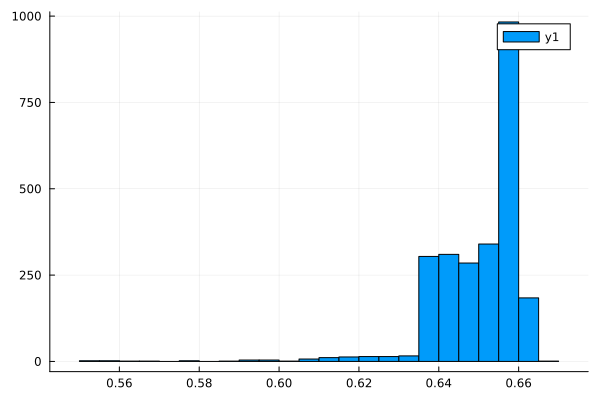

In [218]:
histogram(map(x->matrix_entropy(x),first_networks))

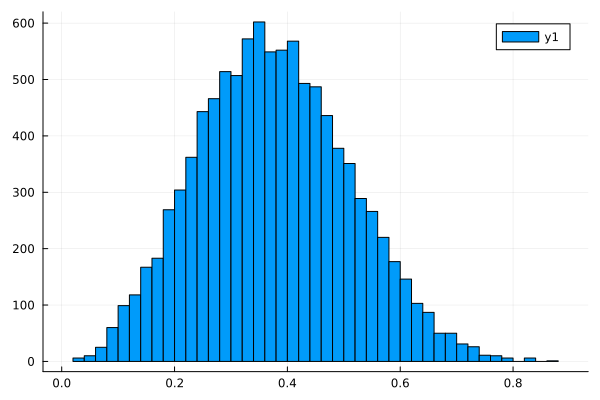

In [219]:
histogram(map(x->matrix_entropy(rand(3,4)),1:10000))

In [220]:
log(2)

0.6931471805599453

In [221]:
evo_traces = map(x->x[2],run_data);
traversed_networks = map(et->unique(et.traversed_topologies),evo_traces);
traversed_networks_all = map(et->reduce(hcat,map(x->vec(x),et.traversed_topologies)),evo_traces);

fitness_traj = map(et->map(x->x[2],et.fitness_trajectory),evo_traces);

In [222]:
function get_unique_weight_fitness(traversed_networks_all,fitness_traj,weight_n)
    uni_pair_list = []
    for i in 1:length(fitness_traj)
        uni_pair = unique(reduce(hcat,[traversed_networks_all[i][weight_n,:],fitness_traj[i]]),dims = 1)
        push!(uni_pair_list,uni_pair)
    end

    return reduce(vcat,uni_pair_list)
end

function get_unique_weight_fitness_mo(traversed_networks_all,fitness_traj,weight_n)
    uni_pair_list = []
    for i in 1:length(fitness_traj)
        uni_pair = unique(reduce(hcat,[traversed_networks_all[i][weight_n,:],fitness_traj[i]]),dims = 1)
        push!(uni_pair_list,uni_pair)
    end

    return reduce(vcat,uni_pair_list)
end


function get_unique_weight_fitness_dr(traversed_networks_all,fitness_traj,weight_n)
    uni_pair_list = []
    for i in 1:length(fitness_traj)
        uni_pair = unique(reduce(hcat,[traversed_networks_all[i][weight_n,:],fitness_traj[i]]),dims = 1)
        push!(uni_pair_list,uni_pair)
    end

    return uni_pair_list
end

get_unique_weight_fitness_dr (generic function with 1 method)

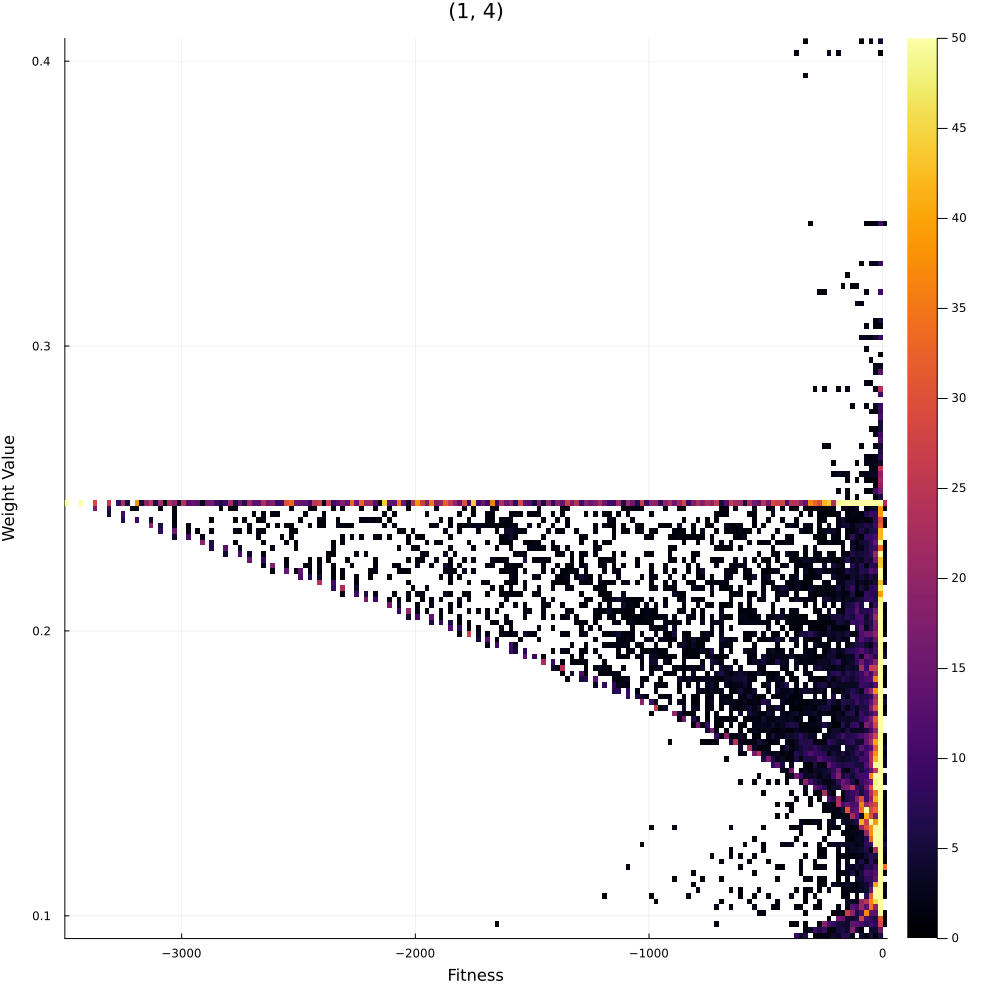

In [226]:
n = 10

v = get_unique_weight_fitness(traversed_networks_all,fitness_traj,n);

f = histogram2d(-1 .* v[:,2],v[:,1],xaxis = "Fitness",yaxis = "Weight Value",clims = (0,50),bins = 200,size = (1000,1000),title = matrix_entries[n])

In [227]:
# n = 4

# v = get_unique_weight_fitness_dr(traversed_networks_all,fitness_traj,n);

# p = plot(size = (1000,1000))

# for i in 1:length(v)

#     StatsPlots.plot!(p,v[i][:,2],v[i][:,1],seriestype = :path,legend = false)
# end

# p

In [228]:
# using PyPlot

# pygui(true)

# linspace(a,b,n) = collect(range(a,stop=b,length=n))

# function meshgrid(vx::AbstractVector{T}, vy::AbstractVector{T}) where T
#     m, n = length(vy), length(vx)
#     vx = reshape(vx, 1, n)
#     vy = reshape(vy, m, 1)
#     (repeat(vx, m, 1), repeat(vy, 1, n))
# end

# using PyPlot

# x,y = ([linspace(-3,3,100);],[linspace(-3,3,100);])
# X,Y = meshgrid(x,y)
# U = -1 .- X.^2 .+ Y
# V =  1 .+ X    .- Y.^2
# speed = sqrt.(U.*U + V.*V)

# start = [0 0]

# streamplot(x,y, U, V)
# streamplot(x,y, U, V, start_points=start)#, color="crimson", linewidth=2)
# p = plot(start[:,1],start[:,2])

# xlim(-3.0,3.0)
# ylim(-3.0,3.0)

# streamplot(x,y, U, V,start_points=start)
# show()


In [229]:
# f = CairoMakie.Figure(resolution = (800, 800))
# Axis(f[1, 1], backgroundcolor = "black")

# xs = LinRange(0, 2pi, 20)
# ys = LinRange(0, 3pi, 20)
# us = [sin(x) * cos(y) for x in xs, y in ys]
# vs = [-cos(x) * sin(y) for x in xs, y in ys]
# strength = vec(sqrt.(us .^ 2 .+ vs .^ 2))

# arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.3,
#     arrowcolor = strength, linecolor = strength)

# f

In [230]:
v = get_unique_weight_fitness(traversed_networks_all,fitness_traj,n);

In [231]:
vdr = get_unique_weight_fitness_dr(traversed_networks_all,fitness_traj,n);

In [232]:
function fit_arrows_to_grid(traversed_networks_all,fitness_traj,weight_n,nbins)

    uni_pair_list = []

    for i in 1:length(fitness_traj)
        uni_pair = unique(reduce(hcat,[-1 .* fitness_traj[i],traversed_networks_all[i][weight_n,:]]),dims = 1)
        push!(uni_pair_list,uni_pair)
    end

    data =  reduce(vcat,uni_pair_list)

    h = fit(Histogram, Tuple(eachcol(data)); nbins=(nbins, nbins)) # how to finely control on size of 2d-bins ??
    x_s = collect(h.edges[1])
    y_s = collect(h.edges[2])

    nx = length(x_s)
    ny = length(y_s)

    # # bin_ids = map(xi -> StatsBase.binindex(h, Tuple(xi)), eachrow(data))

    all_diff_x = []
    all_diff_y = []
    all_bid = []

    for i in 1:length(fitness_traj)
        uni_pair = unique(reduce(hcat,[-1 .* fitness_traj[i],traversed_networks_all[i][weight_n,:]]),dims = 1)
        for di in 1:size(uni_pair,1)-1
            diff_x = uni_pair[di+1,1] - uni_pair[di,1]
            diff_y = uni_pair[di+1,2] - uni_pair[di,2]
            bid = StatsBase.binindex(h, Tuple(uni_pair[di,:]))
            push!(all_diff_x,diff_x)
            push!(all_diff_y,diff_y)
            push!(all_bid,bid)
        end
    end    

    arrow_grid_x = zeros(nx,ny)
    arrow_grid_y = zeros(nx,ny)
    strength = zeros(nx,ny)
    strength_s = zeros(nx,ny)

    for t in unique(all_bid)

        sample_point_ids = findall(x->x==t, all_bid)

        vx = mean(all_diff_x[sample_point_ids])
        vy = mean(all_diff_y[sample_point_ids])

        vxs = std(all_diff_x[sample_point_ids])
        vys = std(all_diff_y[sample_point_ids])

        arrow_grid_x[t...] = vx 
        arrow_grid_y[t...] = vy
        # strength[t...] = sqrt(vx^2 + vy^2)

        strength[t...] = length(sample_point_ids)
        strength_s[t...] = sqrt(vxs^2 + vys^2)
    end

    return x_s,y_s,arrow_grid_x,arrow_grid_y,strength,strength_s

    # return nx,ny,all_diff_x,all_diff_y,all_bid
    
end

fit_arrows_to_grid (generic function with 1 method)

In [233]:
# nx,ny,all_diff_x,all_diff_y,all_bid = fit_arrows_to_grid(traversed_networks_all,fitness_traj,10,200)

# xs, ys, dx, dy,strength, strength_s = fit_arrows_to_grid(traversed_networks_all,fitness_traj,10,50)

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots /Users/boothh/.julia/packages/Plots/qgrW8/src/args.jl:1609


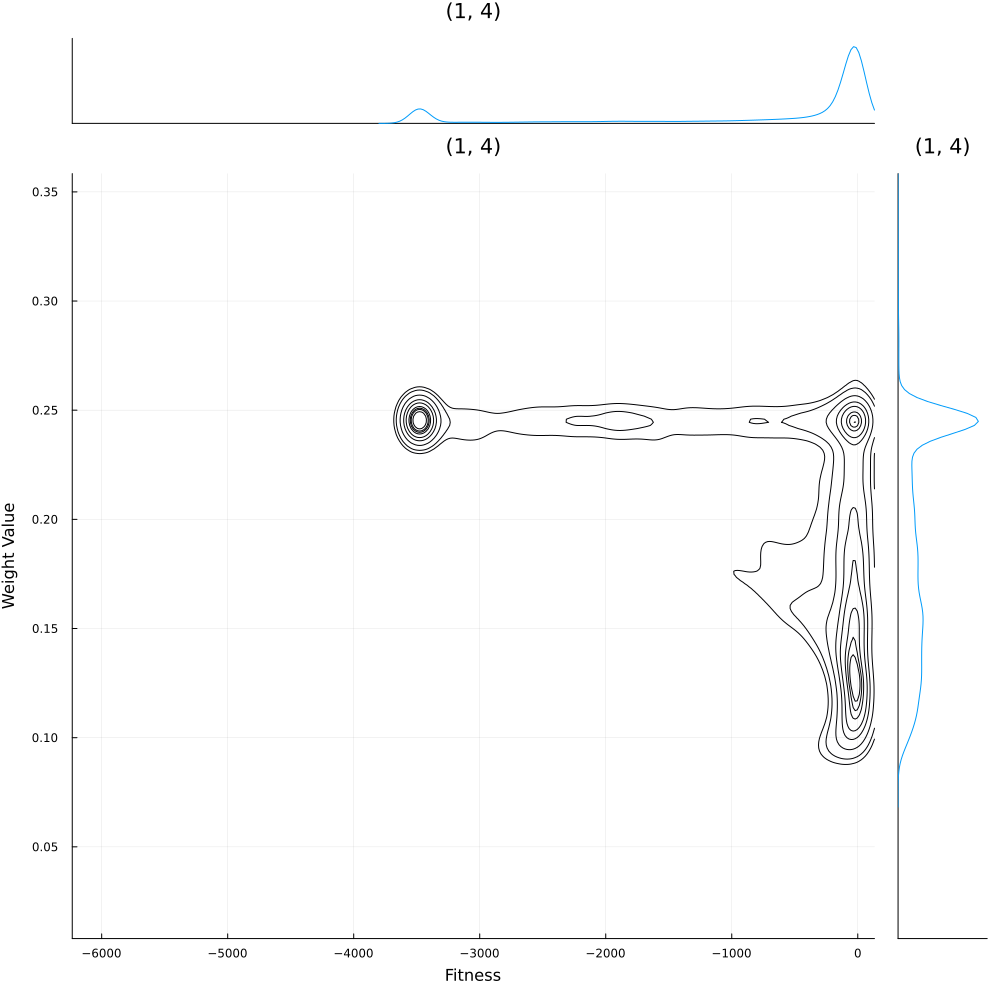

In [254]:
n = 10

v = get_unique_weight_fitness(traversed_networks_all,fitness_traj,n);

f = marginalkde(-1 .* v[:,2],v[:,1],xaxis = "Fitness",yaxis = "Weight Value",clims = (0,50),bins = 200,size = (1000,1000),title = matrix_entries[n])


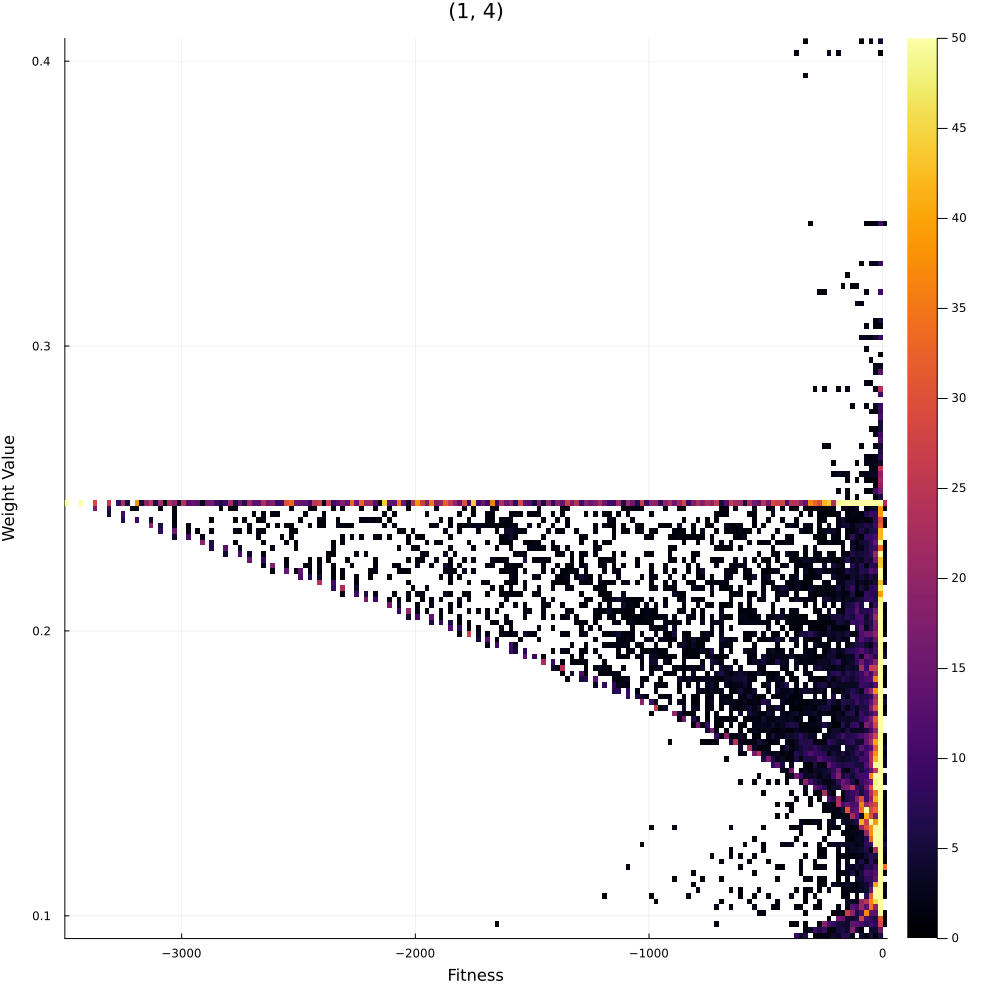

In [255]:
n = 10

v = get_unique_weight_fitness(traversed_networks_all,fitness_traj,n);

f = histogram2d(-1 .* v[:,2],v[:,1],xaxis = "Fitness",yaxis = "Weight Value",clims = (0,50),bins = 200,size = (1000,1000),title = matrix_entries[n])


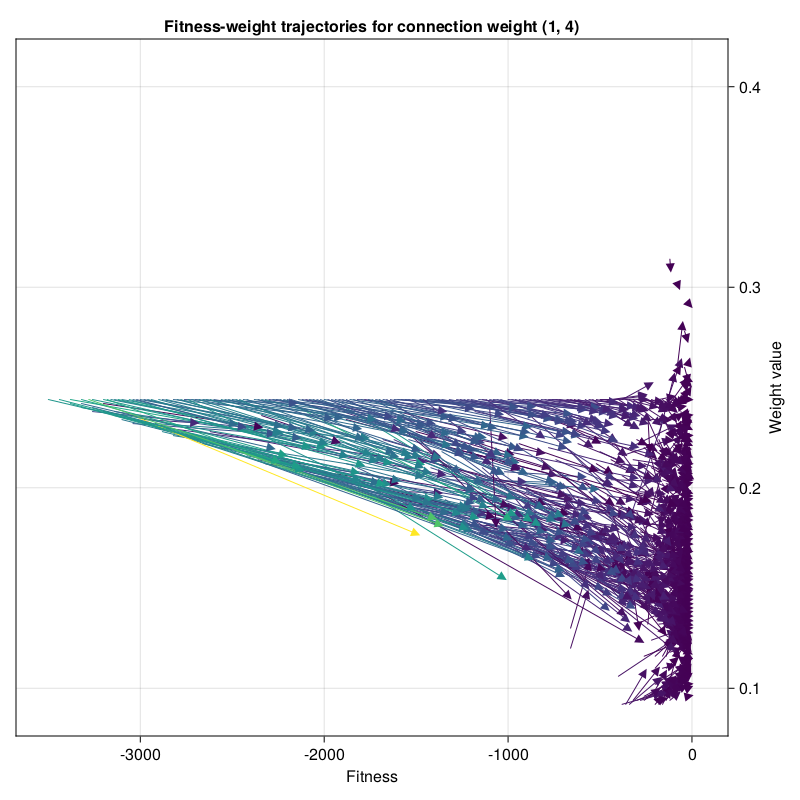

In [252]:
xs, ys, dx, dy,strength, strength_s = fit_arrows_to_grid(traversed_networks_all,fitness_traj,n,200)

dx = map(x->x== 0 ? NaN : x,dx)

dy = map(x->x== 0 ? NaN : x,dy)

fig = CairoMakie.Figure(resolution = (800, 800))
# Axis(f[1, 1], backgroundcolor = "white")

ax1  = Axis(fig[1,1], backgroundcolor = "white", xlabel = "Fitness", ylabel = "Weight value", title = "Fitness-weight trajectories for connection weight " * string(matrix_entries[n]))

arrows!(ax1,xs, ys, dx ,dy,arrowcolor = vec(strength_s), linecolor = vec(strength_s))

ax1.yaxisposition = :right
ax2.yticklabelalign = (:left, :center)

fig